### Import section

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from skimage import color
from skimage.feature import hog

In [2]:
import warnings
import itertools
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# !pip install visualkeras
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# General parameters
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# pip install opencv-python
import cv2
import os

folder_path = "ds_two"             # base/root directory

no_tumor = os.listdir(folder_path + '/no_tumor/')
glioma = os.listdir(folder_path + '/glioma/')
meningioma = os.listdir(folder_path + '/meningioma/')
pituitary = os.listdir(folder_path + '/pituitary/')
craniopharyngioma = os.listdir(folder_path + '/craniopharyngioma/')

# no_tumor, glioma, meningioma, pituitary, craniopharyngioma

dataset=[]
lab=[]

In [6]:
for image_name in no_tumor:
    image=cv2.imread(folder_path + '/no_tumor/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)

In [7]:
for image_name in glioma:
    image=cv2.imread(folder_path + '/glioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)

In [8]:
for image_name in meningioma:
    image=cv2.imread(folder_path + '/meningioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)

In [9]:
for image_name in pituitary:
    image=cv2.imread(folder_path + '/pituitary/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [10]:
for image_name in craniopharyngioma:
    image=cv2.imread(folder_path + '/craniopharyngioma/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(4)

In [11]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(7103, 240, 240, 3) (7103,)


### Deep Feature Extraction

In [12]:
from tensorflow.keras.applications import VGG16

model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

from tensorflow.keras.applications.vgg16 import preprocess_input

dataset = preprocess_input(np.array(dataset))

58900480/58889256 [==============================] - 80s 1us/step


In [13]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)

subdirectories = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

# Create a generator for the images in the subdirectories
generator = datagen.flow_from_directory(
    folder_path,
    target_size=(240,240),
    batch_size=32,
    class_mode='categorical',
#     class_mode=None,
    shuffle=False,
    classes=subdirectories)

Found 7103 images belonging to 5 classes.


In [14]:
features = model.predict(generator, verbose=1)

222/222 [==============================] - 90s 326ms/step


In [15]:
print(len(features))

7103


In [16]:
print("Number of extracted deep features:", features.shape[1])

Number of extracted deep features: 7


In [17]:
np.save('extracted_features_vgg_70_updated.npy', features)

In [18]:
features.shape

(7103, 7, 7, 512)

In [19]:
from tensorflow.keras.layers import Input

# Flatten the features to use them for classification
features_flatten = np.reshape(features, (features.shape[0], -1))

# Define the labels for the images in the subdirectories
labels = generator.classes

### SVM

In [31]:
from sklearn.svm import SVC

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features_flatten, labels, test_size=0.2, random_state=42)

# Initialize and train an SVC model
svc_model = SVC(kernel='linear', probability = True)
svc_model.fit(train_features, train_labels)

# Predict the labels of the testing set using the trained SVC model
predicted_labels = svc_model.predict(test_features)

# Generate a classification report and confusion matrix
report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

                   precision    recall  f1-score   support

         no_tumor       0.99      0.98      0.99       417
           glioma       0.98      0.96      0.97       335
       meningioma       0.92      0.98      0.95       321
        pituitary       0.98      0.98      0.98       336
craniopharyngioma       0.60      0.25      0.35        12

         accuracy                           0.97      1421
        macro avg       0.89      0.83      0.85      1421
     weighted avg       0.97      0.97      0.97      1421



In [32]:
print(matrix)

[[410   2   4   0   1]
 [  0 321  14   0   0]
 [  1   3 314   3   0]
 [  0   1   6 328   1]
 [  2   0   4   3   3]]


In [33]:
from sklearn.metrics import r2_score
r2_score(test_labels, predicted_labels)

0.937708360274504

In [34]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

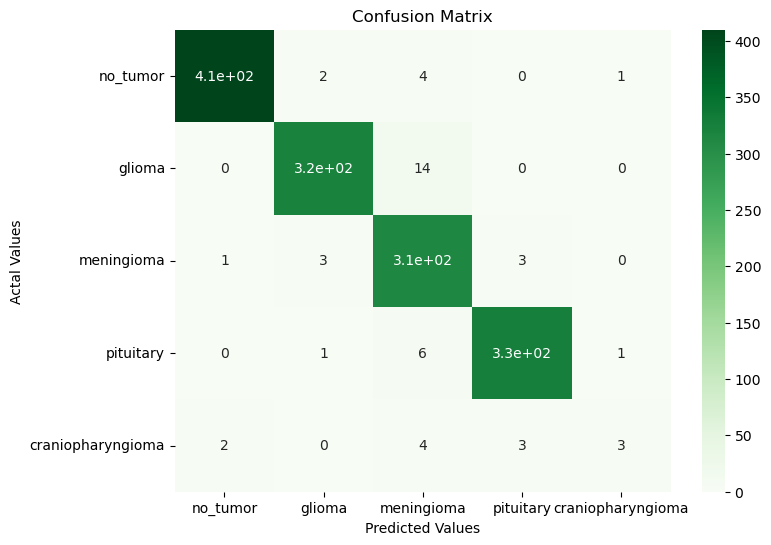

In [35]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [36]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.9683321604503871

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9683321604503871

In [38]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.9683321604503871

In [39]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.9683321604503871

In [40]:
test_labels.shape

(1421,)

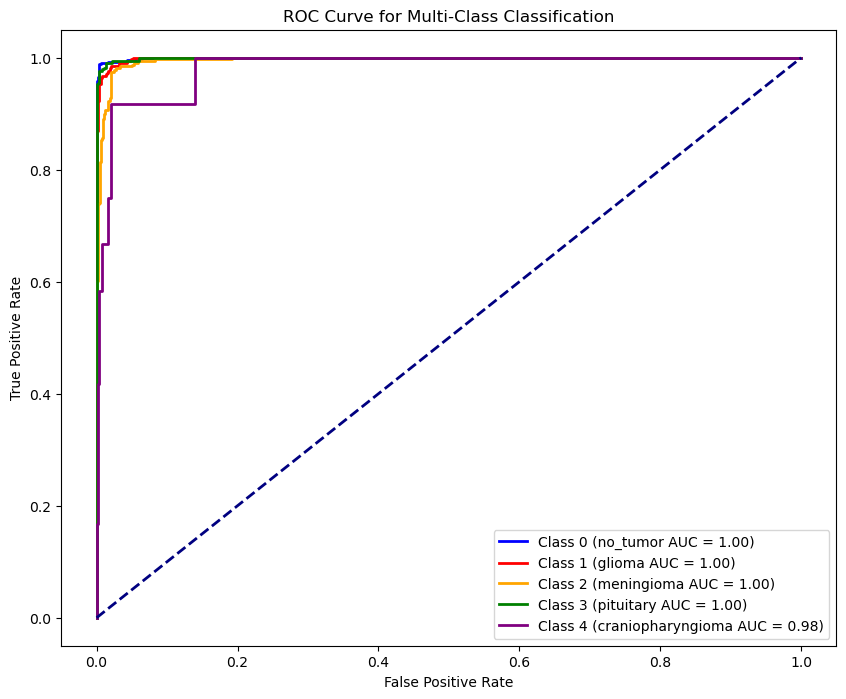

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

y_true = test_labels

y_prob = svc_model.predict_proba(test_features)

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.arange(5))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

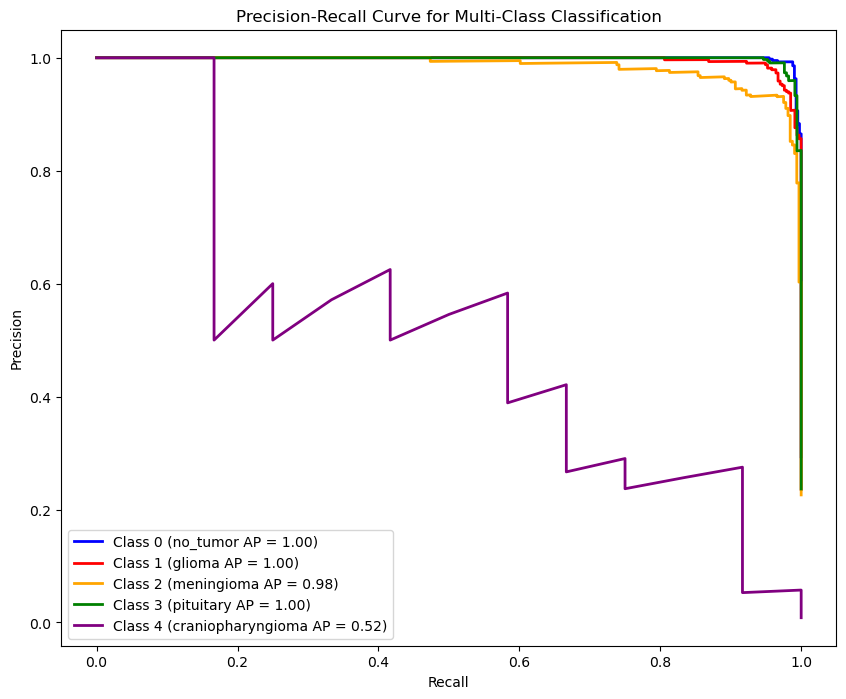

In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize arrays for precision-recall curve
precision = dict()
recall = dict()
average_precision = dict()


for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()

[[410   2   4   0   1]
 [  0 321  14   0   0]
 [  1   3 314   3   0]
 [  0   1   6 328   1]
 [  2   0   4   3   3]]


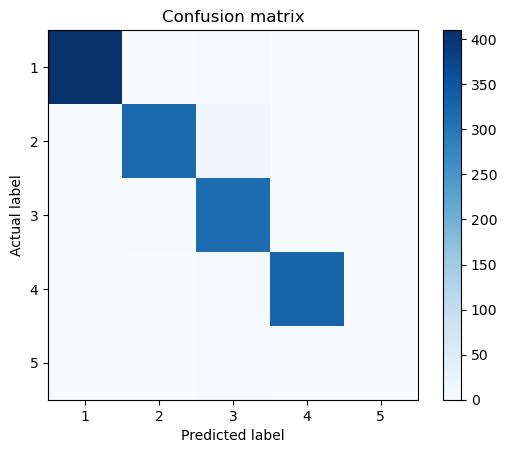

In [43]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Find the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix')
plt.show()

In [44]:
# Import numpy library
import numpy as np

cm = matrix

# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
  tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
  fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
  spec = tn / (tn + fp)

  # Append the specificity to the list
  specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
  print(f"Class {i}: {specificity[i]:.2f}")

Specificity for each class:
Class 0: 0.99
Class 1: 0.99
Class 2: 0.96
Class 3: 0.99
Class 4: 1.00


In [45]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.00
Class 1: 0.01
Class 2: 0.03
Class 3: 0.01
Class 4: 0.00
FNR for each class:
Class 0: 0.02
Class 1: 0.04
Class 2: 0.02
Class 3: 0.02
Class 4: 0.75
TPR for each class:
Class 0: 0.98
Class 1: 0.96
Class 2: 0.98
Class 3: 0.98
Class 4: 0.25
TNR for each class:
Class 0: 1.00
Class 1: 0.99
Class 2: 0.97
Class 3: 0.99
Class 4: 1.00


## Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Rest of the code
train_features, test_features, train_labels, test_labels = train_test_split(
    features_flatten, labels, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)

predicted_labels = rf_model.predict(test_features)

report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

                   precision    recall  f1-score   support

         no_tumor       0.97      0.96      0.97       417
           glioma       0.96      0.88      0.92       335
       meningioma       0.85      0.88      0.87       321
        pituitary       0.88      0.98      0.93       336
craniopharyngioma       0.00      0.00      0.00        12

         accuracy                           0.92      1421
        macro avg       0.73      0.74      0.74      1421
     weighted avg       0.91      0.92      0.91      1421



In [47]:
print(matrix)

[[400   4   6   7   0]
 [  0 295  36   4   0]
 [  4   7 282  28   0]
 [  1   2   5 328   0]
 [  6   0   2   4   0]]


In [48]:
from sklearn.metrics import r2_score
r2_score(test_labels, predicted_labels)

0.8318125727411609

In [49]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

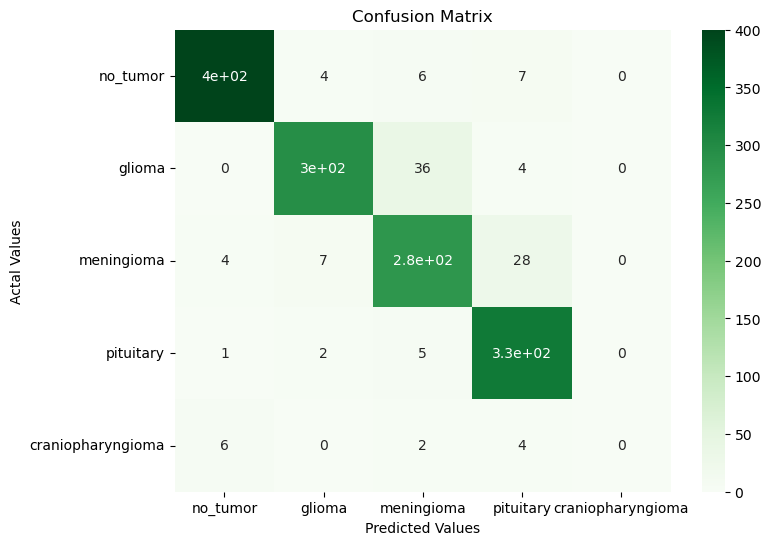

In [50]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [51]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.9183673469387755

In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9183673469387755

In [53]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.9183673469387755

In [54]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.9183673469387755

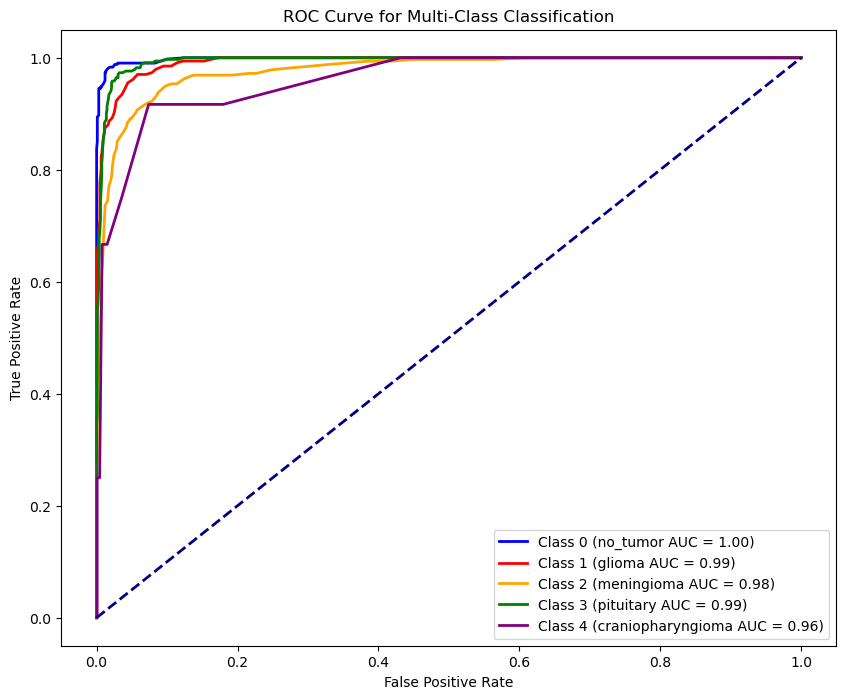

In [55]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

y_true = test_labels

y_prob = rf_model.predict_proba(test_features)

# Binarize the true labels
y_true_bin = label_binarize(test_labels, classes=np.arange(5))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

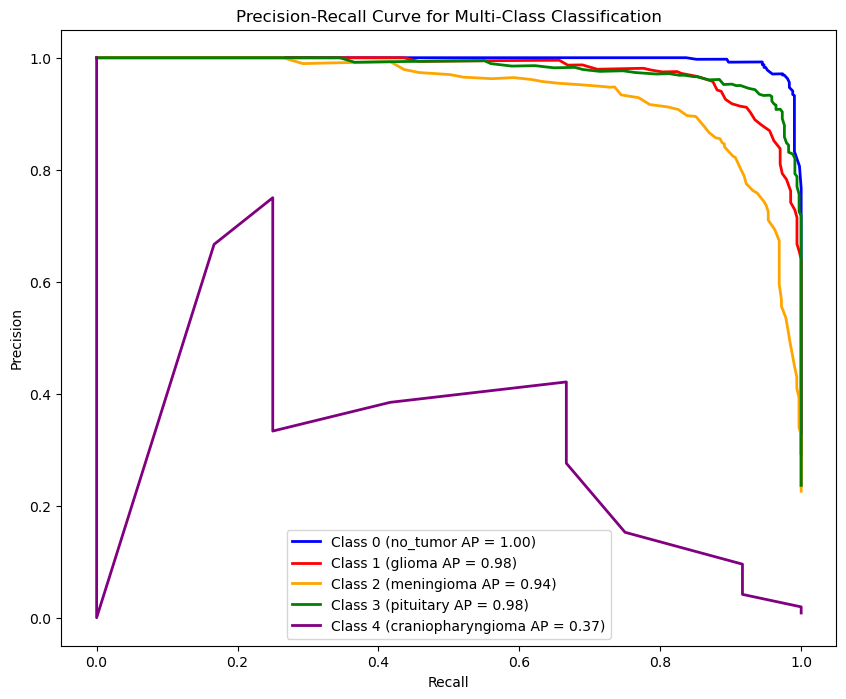

In [56]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize arrays for precision-recall curve
precision = dict()
recall = dict()
average_precision = dict()


for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()

[[400   4   6   7   0]
 [  0 295  36   4   0]
 [  4   7 282  28   0]
 [  1   2   5 328   0]
 [  6   0   2   4   0]]


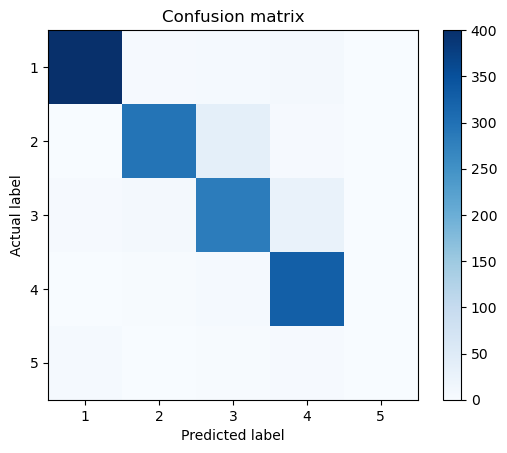

In [57]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Find the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix')
plt.show()

In [58]:
# Import numpy library
import numpy as np

cm = matrix

# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
  tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
  fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
  spec = tn / (tn + fp)

  # Append the specificity to the list
  specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
  print(f"Class {i}: {specificity[i]:.2f}")

Specificity for each class:
Class 0: 0.98
Class 1: 0.98
Class 2: 0.94
Class 3: 0.94
Class 4: 1.00


In [59]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.01
Class 1: 0.01
Class 2: 0.04
Class 3: 0.04
Class 4: 0.00
FNR for each class:
Class 0: 0.04
Class 1: 0.12
Class 2: 0.12
Class 3: 0.02
Class 4: 1.00
TPR for each class:
Class 0: 0.96
Class 1: 0.88
Class 2: 0.88
Class 3: 0.98
Class 4: 0.00
TNR for each class:
Class 0: 0.99
Class 1: 0.99
Class 2: 0.96
Class 3: 0.96
Class 4: 1.00


## XGB

In [60]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()
print(xgbc)

xgbc.fit(train_features, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [61]:
# Predict the labels of the testing set using the trained model
predicted_labels = xgbc.predict(test_features)

# Generate a classification report and confusion matrix
report = classification_report(test_labels, predicted_labels, target_names=subdirectories)
matrix = confusion_matrix(test_labels, predicted_labels)

print(report)

                   precision    recall  f1-score   support

         no_tumor       0.98      0.97      0.97       417
           glioma       0.97      0.93      0.95       335
       meningioma       0.89      0.92      0.91       321
        pituitary       0.94      0.98      0.96       336
craniopharyngioma       1.00      0.08      0.15        12

         accuracy                           0.95      1421
        macro avg       0.95      0.78      0.79      1421
     weighted avg       0.95      0.95      0.94      1421



In [62]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(test_labels, predicted_labels)
cm_df = pd.DataFrame(cm,
                     index = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'],

                     columns = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma'])

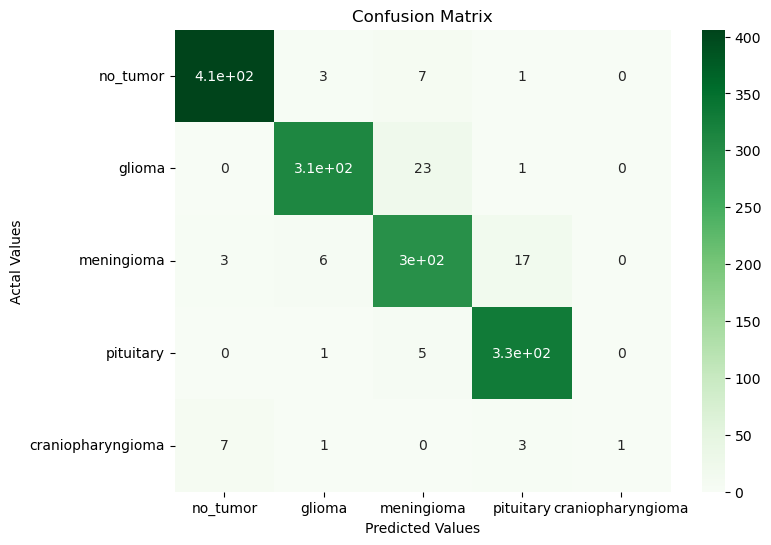

In [63]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9451090781140042

In [65]:
from sklearn.metrics import precision_score
precision_score(test_labels, predicted_labels,average='micro')

0.9451090781140042

In [66]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)

0.9451090781140042

In [67]:
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels,average='micro')

0.9451090781140042

In [68]:
from sklearn.metrics import recall_score
recall_score(test_labels, predicted_labels,average='micro')

0.9451090781140042

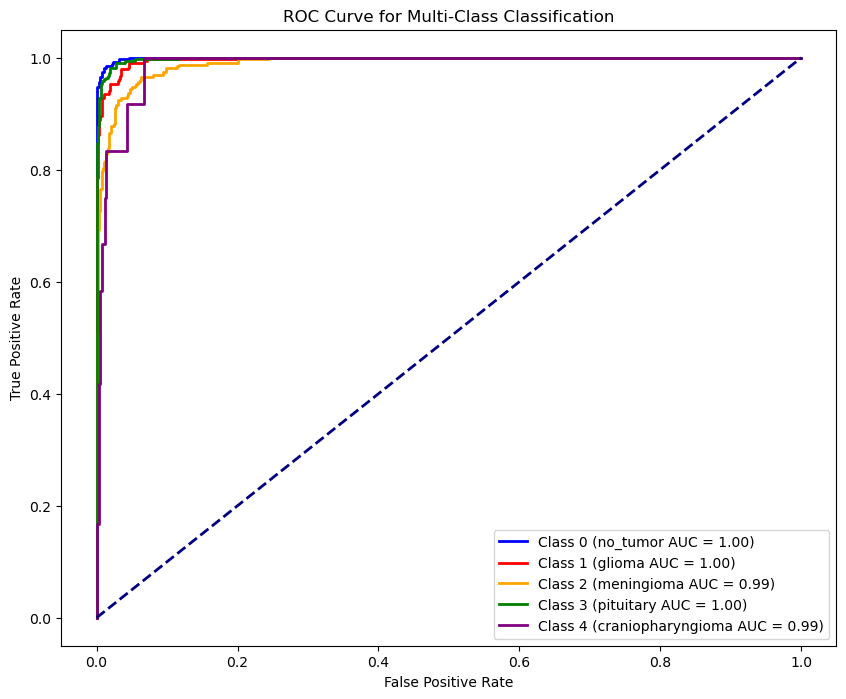

In [69]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import scipy.special

classes = ['no_tumor', 'glioma', 'meningioma', 'pituitary', 'craniopharyngioma']

y_true = test_labels

y_prob = xgbc.predict_proba(test_features)

# Binarize the true labels
y_true_bin = label_binarize(test_labels, classes=np.arange(5))

# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the ROC curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend()
plt.show()

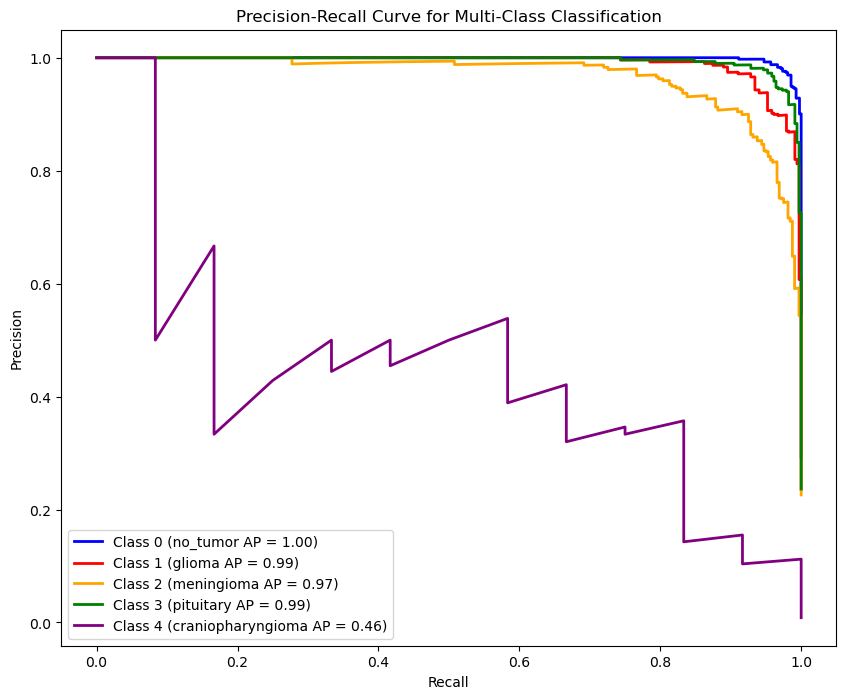

In [70]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Initialize arrays for precision-recall curve
precision = dict()
recall = dict()
average_precision = dict()


for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_prob[:, i])

# Define colors for each class
colors = ['blue', 'red',  'orange', 'green', 'purple']

# Plot the precision-recall curves
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2, label=f'Class {i} ({classes[i]} AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend()
plt.show()

[[406   3   7   1   0]
 [  0 311  23   1   0]
 [  3   6 295  17   0]
 [  0   1   5 330   0]
 [  7   1   0   3   1]]


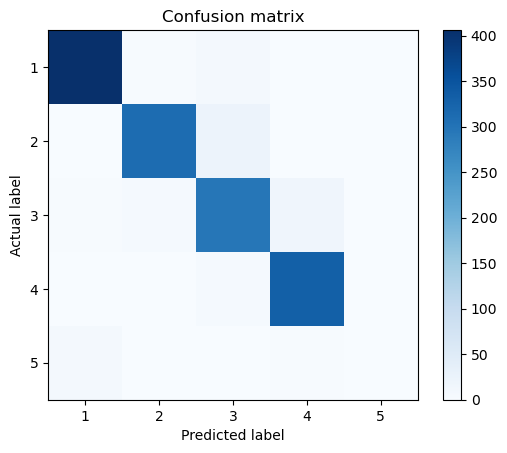

In [71]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Find the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix as a heatmap
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(5), np.arange(1, 6))
plt.yticks(np.arange(5), np.arange(1, 6))
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion matrix')
plt.show()

In [72]:
# Import numpy library
import numpy as np

cm = matrix

# Get the number of classes
n_classes = cm.shape[0]

# Initialize an empty list to store the specificity values
specificity = []

# Loop over each class
for i in range(n_classes):
  # Calculate the true negatives and false positives for class i
  tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i])
  fp = np.sum(cm[:, i]) - cm[i, i]

  # Calculate the specificity for class i
  spec = tn / (tn + fp)

  # Append the specificity to the list
  specificity.append(spec)

# Print the specificity values
print("Specificity for each class:")
for i in range(n_classes):
  print(f"Class {i}: {specificity[i]:.2f}")

Specificity for each class:
Class 0: 0.98
Class 1: 0.99
Class 2: 0.96
Class 3: 0.97
Class 4: 1.00


In [73]:
# Import numpy library
import numpy as np

# Calculate the false positives, false negatives, true positives, and true negatives for each class
fp = np.sum(cm, axis=0) - np.diag(cm)
fn = np.sum(cm, axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = np.sum(cm) - (fp + fn + tp)

# Calculate the false positive rate, false negative rate, true positive rate, and true negative rate for each class
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

# Print the FPR, FNR, TPR, and TNR values for each class
print("FPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fpr[i]:.2f}")

print("FNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {fnr[i]:.2f}")

print("TPR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tpr[i]:.2f}")

print("TNR for each class:")
for i in range(n_classes):
  print(f"Class {i}: {tnr[i]:.2f}")

FPR for each class:
Class 0: 0.01
Class 1: 0.01
Class 2: 0.03
Class 3: 0.02
Class 4: 0.00
FNR for each class:
Class 0: 0.03
Class 1: 0.07
Class 2: 0.08
Class 3: 0.02
Class 4: 0.92
TPR for each class:
Class 0: 0.97
Class 1: 0.93
Class 2: 0.92
Class 3: 0.98
Class 4: 0.08
TNR for each class:
Class 0: 0.99
Class 1: 0.99
Class 2: 0.97
Class 3: 0.98
Class 4: 1.00
